In [ ]:
## Mounting Google Drive
from google.colab import drive, files
drive.mount('/content/drive')
from __future__ import absolute_import, print_function,division, unicode_literals
import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
data_dir ="/content/drive/MyDrive/rsecond"
data_dir = pathlib.Path(data_dir)

CLASS_NAMES = np.array(['bacterial_leaf_blight','brown_spot','healthy','leaf_blast','leaf_scald','narrow_brown_spot'])

print('Class Names: ', CLASS_NAMES)

Class Names:  ['bacterial_leaf_blight' 'brown_spot' 'healthy' 'leaf_blast' 'leaf_scald'
 'narrow_brown_spot']


In [ ]:
train_path = '/content/drive/MyDrive/rsecond/train'
validation_path = '/content/drive/MyDrive/rsecond/validation'

In [ ]:
from keras.preprocessing import image

In [ ]:
train_generator = ImageDataGenerator()
validation_generator = ImageDataGenerator()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_directory('/content/drive/MyDrive/rsecond/train',
                                                     shuffle=True,
                                                     batch_size=10,
                                                     target_size=(224,224),
                                                     class_mode='sparse')


Found 2100 images belonging to 6 classes.


In [ ]:
image_test_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = image_test_gen.flow_from_directory('/content/drive/MyDrive/rsecond/validation',
                                               batch_size=10,
                                               target_size=(224,224),
                                               class_mode='sparse')

Found 528 images belonging to 6 classes.


In [ ]:
def plotImages(image_arr):
    fig,axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

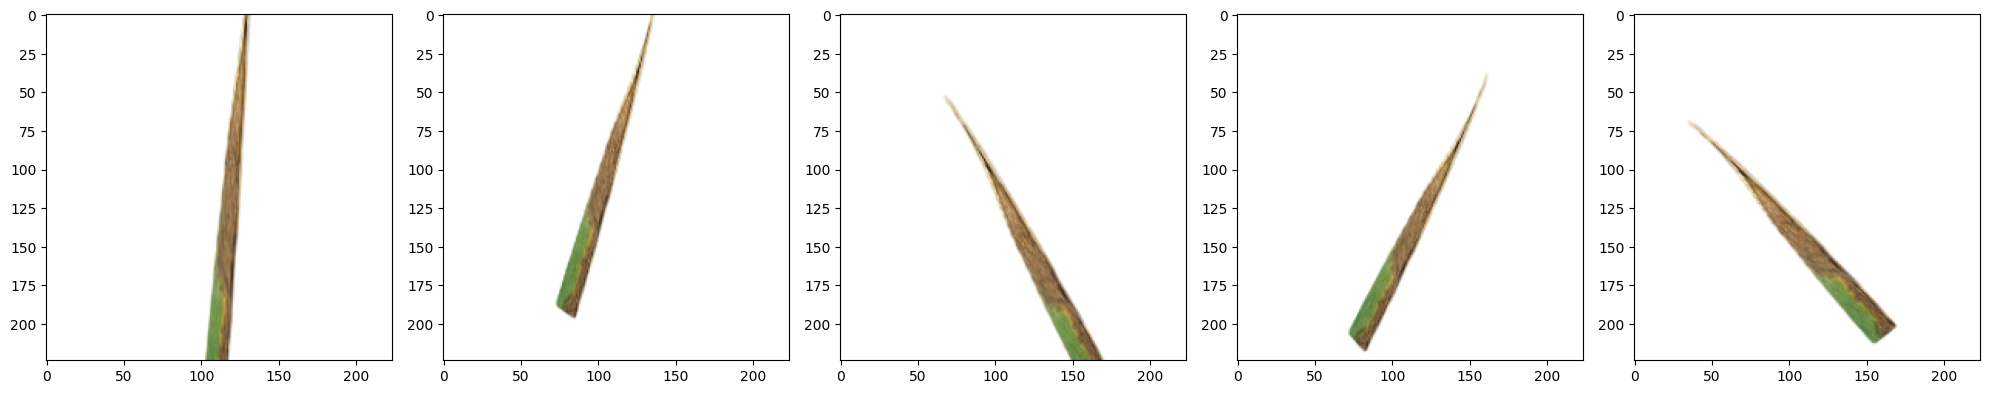

In [ ]:
img_array = [train_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

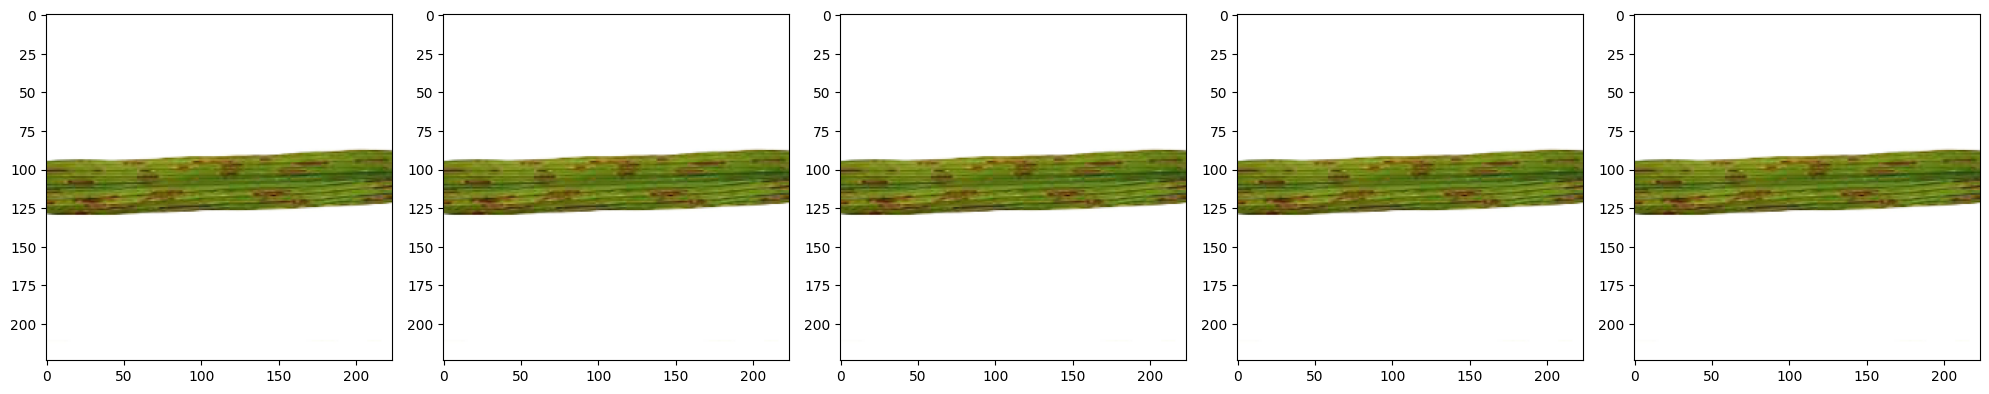

In [ ]:
img_array  = [validation_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
#XCeption
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest", validation_split=0.3)
batch_size = 10

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/rsecond/train',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/rsecond/validation',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='validation')

Found 1470 images belonging to 6 classes.
Found 156 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [ ]:
xception_base = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

In [ ]:
def extract_features_xception(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = validation_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = xception_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * 10 : (i + 1) * 10] = features_batch
            labels[i * 10 : (i + 1) * 10] = labels_batch
        except ValueError:
            break
        i += 1
        if i * 10 >= sample_count:
            break
    return features, labels

In [ ]:
train_features_x, train_labels_x = extract_features_xception('training', 2319)
validation_features_x, validation_labels_x = extract_features_xception('validation', 991)

train_features_x = np.reshape(train_features_x, (2319, 7 * 7 * 2048))
validation_features_x = np.reshape(validation_features_x, (991, 7 * 7 * 2048))

1/1 [==============================] - 2s 2s/step


In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
from keras.backend import learning_phase
from keras.optimizers.schedules import learning_rate_schedule
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 1e-3
EPOCHS = 30


model.compile(loss="binary_crossentropy",optimizer='adam',metrics=["accuracy"])

from keras.callbacks import ReduceLROnPlateau

history2 = model.fit(train_features_x, train_labels_x,
                    epochs=30,
                    batch_size=10,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],shuffle=True)

Epoch 1/30
232/232 [==============================] - ETA: 0s - loss: 1.0417e-05 - accuracy: 0.5330

232/232 [==============================] - 107s 454ms/step - loss: 1.0417e-05 - accuracy: 0.5330 - lr: 0.0010
Epoch 2/30
232/232 [==============================] - ETA: 0s - loss: 5.4748e-07 - accuracy: 0.4718

232/232 [==============================] - 107s 463ms/step - loss: 5.4748e-07 - accuracy: 0.4718 - lr: 0.0010
Epoch 3/30
232/232 [==============================] - ETA: 0s - loss: 2.4436e-07 - accuracy: 0.4825

232/232 [==============================] - 108s 464ms/step - loss: 2.4436e-07 - accuracy: 0.4825 - lr: 0.0010
Epoch 4/30
232/232 [==============================] - ETA: 0s - loss: 1.1193e-07 - accuracy: 0.5153

232/232 [==============================] - 108s 464ms/step - loss: 1.1193e-07 - accuracy: 0.5153 - lr: 0.0010
Epoch 5/30
232/232 [==============================] - ETA: 0s - loss: 1.1302e-07 - accuracy: 0.5300

232/232 [==============================] - 107s 462ms/step - loss: 1.1302e-07 - accuracy: 0.5300 - lr: 0.0010
Epoch 6/30
232/232 [==============================] - ETA: 0s - loss: 1.0031e-07 - accuracy: 0.5132

232/232 [==============================] - 107s 462ms/step - loss: 1.0031e-07 - accuracy: 0.5132 - lr: 0.0010
Epoch 7/30
232/232 [==============================] - ETA: 0s - loss: 2.8915e-08 - accuracy: 0.5239

232/232 [==============================] - 122s 528ms/step - loss: 2.8915e-08 - accuracy: 0.5239 - lr: 0.0010
Epoch 8/30
232/232 [==============================] - ETA: 0s - loss: 3.1954e-08 - accuracy: 0.5235

232/232 [==============================] - 114s 491ms/step - loss: 3.1954e-08 - accuracy: 0.5235 - lr: 0.0010
Epoch 9/30
232/232 [==============================] - ETA: 0s - loss: 3.6196e-08 - accuracy: 0.5261

232/232 [==============================] - 157s 678ms/step - loss: 3.6196e-08 - accuracy: 0.5261 - lr: 0.0010
Epoch 10/30
232/232 [==============================] - ETA: 0s - loss: 4.3826e-08 - accuracy: 0.5339

232/232 [==============================] - 152s 656ms/step - loss: 4.3826e-08 - accuracy: 0.5339 - lr: 0.0010
Epoch 11/30
232/232 [==============================] - ETA: 0s - loss: 1.1182e-08 - accuracy: 0.5403

232/232 [==============================] - 161s 693ms/step - loss: 1.1182e-08 - accuracy: 0.5403 - lr: 0.0010
Epoch 12/30
232/232 [==============================] - ETA: 0s - loss: 1.5705e-08 - accuracy: 0.5270

232/232 [==============================] - 148s 641ms/step - loss: 1.5705e-08 - accuracy: 0.5270 - lr: 0.0010
Epoch 13/30
232/232 [==============================] - ETA: 0s - loss: 9.3313e-09 - accuracy: 0.5364

232/232 [==============================] - 153s 659ms/step - loss: 9.3313e-09 - accuracy: 0.5364 - lr: 0.0010
Epoch 14/30
232/232 [==============================] - ETA: 0s - loss: 7.6952e-09 - accuracy: 0.5011

232/232 [==============================] - 154s 666ms/step - loss: 7.6952e-09 - accuracy: 0.5011 - lr: 0.0010
Epoch 15/30
232/232 [==============================] - ETA: 0s - loss: 8.2823e-09 - accuracy: 0.5024

232/232 [==============================] - 170s 733ms/step - loss: 8.2823e-09 - accuracy: 0.5024 - lr: 0.0010
Epoch 16/30
232/232 [==============================] - ETA: 0s - loss: 7.0119e-09 - accuracy: 0.5024

232/232 [==============================] - 161s 693ms/step - loss: 7.0119e-09 - accuracy: 0.5024 - lr: 0.0010
Epoch 17/30
232/232 [==============================] - ETA: 0s - loss: 5.2572e-09 - accuracy: 0.4899

232/232 [==============================] - 161s 692ms/step - loss: 5.2572e-09 - accuracy: 0.4899 - lr: 0.0010
Epoch 18/30
232/232 [==============================] - ETA: 0s - loss: 6.2349e-09 - accuracy: 0.4873

232/232 [==============================] - 162s 700ms/step - loss: 6.2349e-09 - accuracy: 0.4873 - lr: 0.0010
Epoch 19/30
232/232 [==============================] - ETA: 0s - loss: 4.1638e-09 - accuracy: 0.4817

232/232 [==============================] - 173s 746ms/step - loss: 4.1638e-09 - accuracy: 0.4817 - lr: 0.0010
Epoch 20/30
232/232 [==============================] - ETA: 0s - loss: 9.0988e-09 - accuracy: 0.4493

232/232 [==============================] - 164s 708ms/step - loss: 9.0988e-09 - accuracy: 0.4493 - lr: 0.0010
Epoch 21/30
232/232 [==============================] - ETA: 0s - loss: 4.7628e-09 - accuracy: 0.4424

232/232 [==============================] - 180s 777ms/step - loss: 4.7628e-09 - accuracy: 0.4424 - lr: 0.0010
Epoch 22/30
232/232 [==============================] - ETA: 0s - loss: 3.2677e-09 - accuracy: 0.4592

232/232 [==============================] - 197s 848ms/step - loss: 3.2677e-09 - accuracy: 0.4592 - lr: 0.0010
Epoch 23/30
232/232 [==============================] - ETA: 0s - loss: 3.6426e-09 - accuracy: 0.4549

232/232 [==============================] - 191s 822ms/step - loss: 3.6426e-09 - accuracy: 0.4549 - lr: 0.0010
Epoch 24/30
232/232 [==============================] - ETA: 0s - loss: 2.7189e-09 - accuracy: 0.4618

232/232 [==============================] - 182s 784ms/step - loss: 2.7189e-09 - accuracy: 0.4618 - lr: 0.0010
Epoch 25/30
232/232 [==============================] - ETA: 0s - loss: 2.0252e-09 - accuracy: 0.4463

232/232 [==============================] - 165s 712ms/step - loss: 2.0252e-09 - accuracy: 0.4463 - lr: 0.0010
Epoch 26/30
232/232 [==============================] - ETA: 0s - loss: 2.4473e-09 - accuracy: 0.4450

232/232 [==============================] - 111s 479ms/step - loss: 2.4473e-09 - accuracy: 0.4450 - lr: 0.0010
Epoch 27/30
232/232 [==============================] - ETA: 0s - loss: 6.9710e-09 - accuracy: 0.4015

232/232 [==============================] - 100s 430ms/step - loss: 6.9710e-09 - accuracy: 0.4015 - lr: 0.0010
Epoch 28/30
232/232 [==============================] - ETA: 0s - loss: 1.0521e-09 - accuracy: 0.3911

232/232 [==============================] - 101s 437ms/step - loss: 1.0521e-09 - accuracy: 0.3911 - lr: 0.0010
Epoch 29/30
232/232 [==============================] - ETA: 0s - loss: 2.3536e-09 - accuracy: 0.3984

232/232 [==============================] - 99s 429ms/step - loss: 2.3536e-09 - accuracy: 0.3984 - lr: 0.0010
Epoch 30/30
232/232 [==============================] - ETA: 0s - loss: 6.5736e-10 - accuracy: 0.3734

232/232 [==============================] - 101s 435ms/step - loss: 6.5736e-10 - accuracy: 0.3734 - lr: 0.0010


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/rsecond",
    shuffle=True,
    image_size=(10,10),
    batch_size=10
)

Found 2628 files belonging to 2 classes.


In [ ]:
class_names=dataset.class_names
class_names

['train', 'validation']

In [ ]:
scores=model.evaluate(validation_features_x,validation_labels_x)
scores

31/31 [==============================] - 2s 50ms/step - loss: 3.2091e-13 - accuracy: 0.9990


[3.209085829101316e-13, 0.9989908933639526]

In [ ]:
acc2=history2.history['accuracy']
loss2=history2.history['loss']

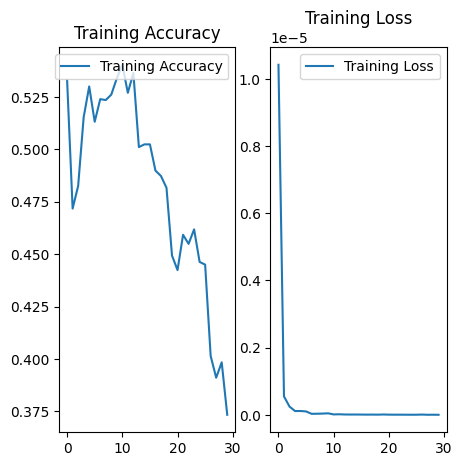

In [ ]:
epochs_range = range(30)
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc2, label='Training Accuracy')
plt.legend(loc='upper right')
plt.title('Training Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss2, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()

In [ ]:
#ResNet
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest", validation_split=0.3)
batch_size = 10

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/rsecond/train',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/rsecond/validation',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    subset='validation')

Found 1470 images belonging to 6 classes.
Found 156 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
resnet_base = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

In [ ]:
def extract_features_resnet(trainorval, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 4))
    if trainorval=="training":
        generator = train_generator
    else:
        generator = val_generator
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_base.predict(preprocess_input(inputs_batch))
        try:
            features[i * 10 : (i + 1) * 10] = features_batch
            labels[i * 10 : (i + 1) * 10] = labels_batch
        except ValueError:
            break
        i += 1
        if i * 10 >= sample_count:
            break
    return features, labels

In [ ]:
train_features_res, train_labels_res = extract_features_resnet('training', 231)
validation_features_res, validation_labels_res = extract_features_resnet('validation', 99)

train_features_res = np.reshape(train_features_res, (231, 7 * 7 * 2048))
validation_features_res = np.reshape(validation_features_res, (99, 7 * 7 * 2048))

1/1 [==============================] - 3s 3s/step


In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  #Removing 50% of the weights!
model.add(layers.Dense(4, activation='softmax'))
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 1e-3
EPOCHS = 30

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

from keras.callbacks import ReduceLROnPlateau

history = model.fit(train_features_res, train_labels_res,
                    epochs=30,
                    batch_size=10,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)], shuffle=True)

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.2035

24/24 [==============================] - 11s 413ms/step - loss: 0.7418 - accuracy: 0.2035 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.1558

24/24 [==============================] - 9s 365ms/step - loss: 0.6181 - accuracy: 0.1558 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.2468

24/24 [==============================] - 10s 428ms/step - loss: 0.2795 - accuracy: 0.2468 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.3636

24/24 [==============================] - 10s 411ms/step - loss: 0.0814 - accuracy: 0.3636 - lr: 0.0010
Epoch 5/30
24/24 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.4502

24/24 [==============================] - 9s 362ms/step - loss: 0.0236 - accuracy: 0.4502 - lr: 0.0010
Epoch 6/30
24/24 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.4805

24/24 [==============================] - 10s 427ms/step - loss: 0.0102 - accuracy: 0.4805 - lr: 0.0010
Epoch 7/30
24/24 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.4848

24/24 [==============================] - 10s 414ms/step - loss: 0.0069 - accuracy: 0.4848 - lr: 0.0010
Epoch 8/30
24/24 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.4935

24/24 [==============================] - 9s 357ms/step - loss: 0.0044 - accuracy: 0.4935 - lr: 0.0010
Epoch 9/30
24/24 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.5065

24/24 [==============================] - 10s 424ms/step - loss: 0.0031 - accuracy: 0.5065 - lr: 0.0010
Epoch 10/30
24/24 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.5022

24/24 [==============================] - 10s 418ms/step - loss: 0.0024 - accuracy: 0.5022 - lr: 0.0010
Epoch 11/30
24/24 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.4848

24/24 [==============================] - 9s 355ms/step - loss: 0.0022 - accuracy: 0.4848 - lr: 0.0010
Epoch 12/30
24/24 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.5584

24/24 [==============================] - 10s 429ms/step - loss: 0.0017 - accuracy: 0.5584 - lr: 0.0010
Epoch 13/30
24/24 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.4632

24/24 [==============================] - 10s 425ms/step - loss: 0.0013 - accuracy: 0.4632 - lr: 0.0010
Epoch 14/30
24/24 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.5281

24/24 [==============================] - 9s 357ms/step - loss: 0.0014 - accuracy: 0.5281 - lr: 0.0010
Epoch 15/30
24/24 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.5065

24/24 [==============================] - 10s 426ms/step - loss: 0.0013 - accuracy: 0.5065 - lr: 0.0010
Epoch 16/30
24/24 [==============================] - ETA: 0s - loss: 9.8460e-04 - accuracy: 0.5455

24/24 [==============================] - 10s 423ms/step - loss: 9.8460e-04 - accuracy: 0.5455 - lr: 0.0010
Epoch 17/30
24/24 [==============================] - ETA: 0s - loss: 8.9130e-04 - accuracy: 0.5281

24/24 [==============================] - 9s 355ms/step - loss: 8.9130e-04 - accuracy: 0.5281 - lr: 0.0010
Epoch 18/30
24/24 [==============================] - ETA: 0s - loss: 7.7370e-04 - accuracy: 0.5411

24/24 [==============================] - 10s 427ms/step - loss: 7.7370e-04 - accuracy: 0.5411 - lr: 0.0010
Epoch 19/30
24/24 [==============================] - ETA: 0s - loss: 7.6222e-04 - accuracy: 0.5238

24/24 [==============================] - 10s 429ms/step - loss: 7.6222e-04 - accuracy: 0.5238 - lr: 0.0010
Epoch 20/30
24/24 [==============================] - ETA: 0s - loss: 6.1578e-04 - accuracy: 0.4935

24/24 [==============================] - 9s 356ms/step - loss: 6.1578e-04 - accuracy: 0.4935 - lr: 0.0010
Epoch 21/30
24/24 [==============================] - ETA: 0s - loss: 5.2778e-04 - accuracy: 0.5411

24/24 [==============================] - 10s 427ms/step - loss: 5.2778e-04 - accuracy: 0.5411 - lr: 0.0010
Epoch 22/30
24/24 [==============================] - ETA: 0s - loss: 5.3844e-04 - accuracy: 0.5498

24/24 [==============================] - 10s 427ms/step - loss: 5.3844e-04 - accuracy: 0.5498 - lr: 0.0010
Epoch 23/30
24/24 [==============================] - ETA: 0s - loss: 5.6702e-04 - accuracy: 0.5628

24/24 [==============================] - 9s 358ms/step - loss: 5.6702e-04 - accuracy: 0.5628 - lr: 0.0010
Epoch 24/30
24/24 [==============================] - ETA: 0s - loss: 3.8450e-04 - accuracy: 0.5281

24/24 [==============================] - 10s 429ms/step - loss: 3.8450e-04 - accuracy: 0.5281 - lr: 0.0010
Epoch 25/30
24/24 [==============================] - ETA: 0s - loss: 4.2874e-04 - accuracy: 0.5541

24/24 [==============================] - 10s 429ms/step - loss: 4.2874e-04 - accuracy: 0.5541 - lr: 0.0010
Epoch 26/30
24/24 [==============================] - ETA: 0s - loss: 3.6042e-04 - accuracy: 0.5584

24/24 [==============================] - 9s 356ms/step - loss: 3.6042e-04 - accuracy: 0.5584 - lr: 0.0010
Epoch 27/30
24/24 [==============================] - ETA: 0s - loss: 2.8752e-04 - accuracy: 0.5325

24/24 [==============================] - 10s 427ms/step - loss: 2.8752e-04 - accuracy: 0.5325 - lr: 0.0010
Epoch 28/30
24/24 [==============================] - ETA: 0s - loss: 4.3453e-04 - accuracy: 0.4935

24/24 [==============================] - 10s 427ms/step - loss: 4.3453e-04 - accuracy: 0.4935 - lr: 0.0010
Epoch 29/30
24/24 [==============================] - ETA: 0s - loss: 3.0331e-04 - accuracy: 0.6061

24/24 [==============================] - 9s 357ms/step - loss: 3.0331e-04 - accuracy: 0.6061 - lr: 0.0010
Epoch 30/30
24/24 [==============================] - ETA: 0s - loss: 2.8711e-04 - accuracy: 0.5411

24/24 [==============================] - 10s 425ms/step - loss: 2.8711e-04 - accuracy: 0.5411 - lr: 0.0010


In [ ]:
scores=model.evaluate(validation_features_res,validation_labels_res)
scores

4/4 [==============================] - 0s 35ms/step - loss: 5.3919e-05 - accuracy: 1.0000


[5.391935701481998e-05, 1.0]

In [ ]:
acc=history.history['accuracy']
loss=history.history['loss']

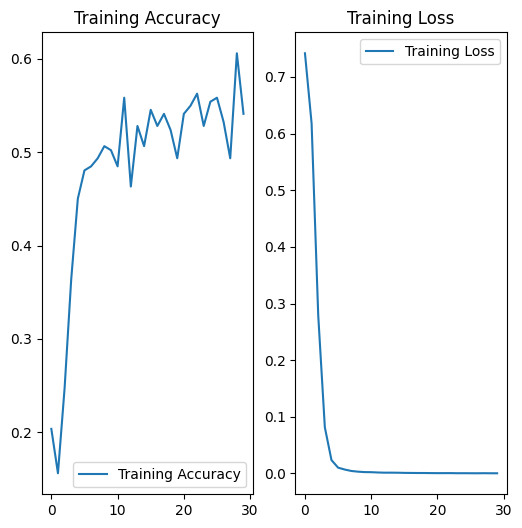

In [ ]:
epochs_range = range(30)
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc2,label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss2, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()